In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [3]:
# expected = np.load("../tests/okada_western_north_america_expected.npz")["arr_0"]
# actual = np.load("../tests/okada_western_north_america_actual.npz")["arr_0"]

expected = np.load("../tests/okada_japan_expected.npz")["arr_0"]
actual = np.load("../tests/okada_japan_actual.npz")["arr_0"]

In [4]:
np.isnan(expected).mean(), np.isnan(actual).mean()

(0.0, 0.0)

/home/mares/micromamba/envs/celeri/lib/python3.12/site-packages/xarray/core/computation.py:824: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


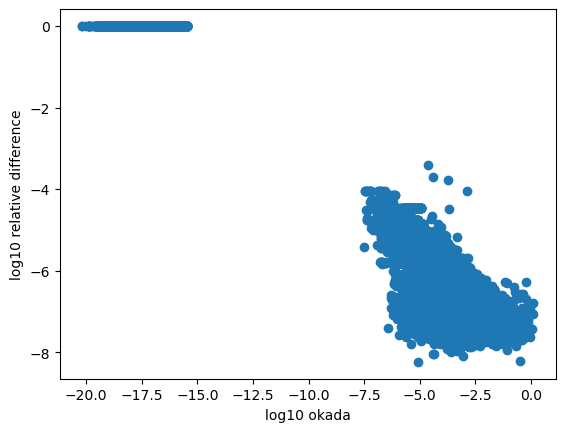

In [5]:
n_segments = 481
n_stations = 954

reshaped_cutde = actual.reshape(n_stations, 3, n_segments, 3)
reshaped_okada = expected.reshape(n_stations, 3, n_segments, 3)
# (station, displacement, segment, slip_type)

displacement = ["east", "north", "up"]
slip_type = ["strike", "dip", "tensile"]
algorithm = ["okada", "cutde", "difference"]

combined = np.stack([reshaped_okada, reshaped_cutde, reshaped_okada - reshaped_cutde])

results = xr.DataArray(
    combined,
    dims=["algorithm", "station", "displacement", "segment", "slip_type"],
    coords={
        "station": np.arange(n_stations),
        "displacement": displacement,
        "segment": np.arange(n_segments),
        "slip_type": slip_type,
        "algorithm": algorithm,
    },
)

results.sel(
    algorithm="cutde", station=1, displacement="north", segment=29, slip_type="tensile"
)

# Take squared-norms along the displacement and slip_type dimensions
norms = np.sqrt(np.square(results).sum(dim=["displacement", "slip_type"]))

# Set the glitched value to 0 by hand
glitched_value = norms.values[2,10,245]
norms.values[2,10,245] = 0

# If okada is zero, then cutde is also zero. Thus we only need to look at values where
# okada is nonzero, and this lets us take logs.
assert ((norms.sel(algorithm="okada") == 0) & (norms.sel(algorithm="cutde") != 0)).sum().item() == 0

# Logarithmic scatter plot of the norms, x-axis is algorithm="okada", y-axis is algorithm="difference"
plt.scatter(np.log10(norms.sel(algorithm="okada")), np.log10(norms.sel(algorithm="difference")) - np.log10(norms.sel(algorithm="okada")))
plt.xlabel("log10 okada")
plt.ylabel("log10 relative difference")
plt.show()

# Reset the glitched value
norms.values[2,10,245] = glitched_value


In [6]:
norms.sel(segment=245, station=10)

<xarray.DataArray (algorithm: 3)> Size: 24B
array([7.14203808e-06, 4.81167350e-06, 2.87719346e-06])
Coordinates:
    station    int64 8B 10
    segment    int64 8B 245
  * algorithm  (algorithm) <U10 120B 'okada' 'cutde' 'difference'

In [7]:
results.sel(segment=245, station=10, displacement="up", slip_type="tensile")

<xarray.DataArray (algorithm: 3)> Size: 24B
array([6.27948521e-06, 3.40229174e-06, 2.87719346e-06])
Coordinates:
    station       int64 8B 10
    displacement  <U5 20B 'up'
    segment       int64 8B 245
    slip_type     <U7 28B 'tensile'
  * algorithm     (algorithm) <U10 120B 'okada' 'cutde' 'difference'